In [17]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import save_image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
sns.set_theme()
torch.set_default_dtype(torch.float32)

In [2]:
class Encoder(nn.Module):
    def __init__(self,sizes):
        super().__init__()
        self.latent_size=sizes[-1]
        self.network=[]
        for i in range(len(sizes)-2):
            self.network.append(nn.Linear(sizes[i],sizes[i+1]))
            self.network.append(nn.ReLU())
        self.encode_mu=nn.Linear(sizes[-2],sizes[-1])
        self.encode_sigma=nn.Linear(sizes[-2],sizes[-1])
        self.network=nn.Sequential(*self.network)

    def forward(self,x):
        x=self.network(x)
        mu=self.encode_mu(x)
        sigma=torch.exp(self.encode_sigma(x))
        return mu,sigma



class Decoder(nn.Module):
    def __init__(self,sizes):
        super().__init__()
        self.network=[]
        for i in range(len(sizes)-2):
            self.network.append(nn.Linear(sizes[i],sizes[i+1]))
            self.network.append(nn.ReLU())
        self.network.append(nn.Linear(sizes[-2],sizes[-1]))
        self.network=nn.Sequential(*self.network)

    def forward(self,x):
        return torch.sigmoid(self.network(x))

class VAE_torch(nn.Module):
    def __init__(self,encoder, decoder,latent_size,device="cpu"):
        super().__init__()
        self.latent_size=latent_size
        self.encoder=encoder.to(device)
        self.decoder=decoder.to(device)
        self.device=device
    
    def forward(self,x):
        mu,sigma=self.encoder(x)
        eps=torch.normal(0,1,(mu.shape[0],self.latent_size),device=self.device)
        sampled_vector=mu+eps*sigma
        return self.decoder(sampled_vector),mu,sigma

    def sample(self,x):
        mu,sigma=self.encoder(x)
        sampled_vector=torch.zeros(x.shape[0],self.latent_size,device=self.device)
        for j in range(mu.shape[0]):
            sampled_vector[j,:]=torch.distributions.Normal(mu[j],sigma[j]).sample()
        print(sampled_vector,sampled_vector.device)
        return self.decoder(sampled_vector)

    def embed(self,x):
        with torch.no_grad():
            mu,sigma=self.encoder(x)
        return mu



def KL(mean,sigma):
    return 0.5*torch.sum((torch.sum(sigma.pow(2),dim=1)+torch.sum(mean.pow(2),dim=1)-torch.sum(torch.log(sigma.pow(2)),dim=1)-1))

def ELBO(values,pred_values,mean,sigma,beta=1):
    return (nn.functional.binary_cross_entropy(pred_values, values,reduction="sum")+beta*KL(mean,sigma))/values.shape[0]

def ELBO_MSE(values,pred_values,mean,sigma,beta=1):
    return (nn.functional.mse_loss(pred_values,values,reduction="sum")+beta*KL(mean,sigma))/values.shape[0]

def visualize(res1,VAE):
    new=VAE.sample(res1.expand(5,784))
    f,axes=plt.subplots(2,3,figsize=(21,14))
    ax=axes.flatten()[0]
    ax.imshow(res1.cpu().numpy().reshape(28,28),cmap="viridis_r")
    ax.set_title("Original image")
    for spine in ax.spines.values():
        spine.set_edgecolor('red')
        spine.set_linewidth(4)
    for j in range(5):
        ax=axes.flatten()[j+1]
        ax.imshow(new[j,:].detach().cpu().numpy().reshape(28,28),cmap="viridis_r")
    plt.tight_layout()


def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']
        
    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.
    
    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1
    
    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (torch.tensor(x_train,dtype=torch.float32), torch.tensor(y_train,dtype=torch.float32)), (torch.tensor(x_test,dtype=torch.float32),torch.tensor(y_test,dtype=torch.float32))

def generate(VAE,n,name="images.png"):
    input=torch.normal(0,1,[n*n,VAE.latent_size])
    output=VAE.decoder(input.to(VAE.device))
    save_image(output.reshape(n*n,1,28,28),name)

In [15]:
(xtrain,ytrain),(xtest,ytest)=load_mnist()
id=np.sum(ytrain.numpy()*np.arange(0,10),axis=1)

In [4]:
num_epoch=40
batch=100
use_gpu=True
if use_gpu:
    VAE=VAE_torch(Encoder([784,110,30,10]),Decoder([10,30,110,784]),10,"cuda")
    device = torch.device("cuda")
    xtrain=xtrain.to(device)
    xtest=xtest.to(device)
else:
    VAE=VAE_torch(Encoder([784,110,30,10]),Decoder([10,30,110,784]),10)
optim=torch.optim.Adam(VAE.parameters(),lr=0.003)
beta=1
err_train=[]
err_test=[]
for i in range(num_epoch):
    for j in range(0,60000,batch):
        xbatch=xtrain[j:j+batch]
        optim.zero_grad()
        results,mean,sigma=VAE(xbatch)
        loss=ELBO(xbatch,results,mean,sigma,beta=beta)
        loss.backward()
        optim.step()
    with torch.no_grad():
        test_res,mean,sigma=VAE(xtest)
        loss_test=ELBO(xtest,test_res,mean,sigma,beta=beta)
        print("Epoche: ",i,"loss train: {:.3f}".format(loss.item()),"loss test: {:.3f}".format(loss_test.item()))
        err_train.append(loss.item())
        err_test.append(loss_test.item())

Epoche:  0 loss train: 179.531 loss test: 166.124
Epoche:  1 loss train: 148.857 loss test: 146.394
Epoche:  2 loss train: 137.193 loss test: 138.834
Epoche:  3 loss train: 134.053 loss test: 134.876
Epoche:  4 loss train: 130.207 loss test: 133.926
Epoche:  5 loss train: 128.841 loss test: 130.964
Epoche:  6 loss train: 129.029 loss test: 131.824
Epoche:  7 loss train: 128.581 loss test: 130.935
Epoche:  8 loss train: 127.791 loss test: 129.598
Epoche:  9 loss train: 127.055 loss test: 129.171
Epoche:  10 loss train: 127.840 loss test: 128.019
Epoche:  11 loss train: 127.908 loss test: 129.164
Epoche:  12 loss train: 128.591 loss test: 128.763
Epoche:  13 loss train: 126.033 loss test: 127.699
Epoche:  14 loss train: 127.778 loss test: 127.358
Epoche:  15 loss train: 126.160 loss test: 127.534
Epoche:  16 loss train: 125.389 loss test: 126.149
Epoche:  17 loss train: 126.147 loss test: 127.945
Epoche:  18 loss train: 126.760 loss test: 126.915
Epoche:  19 loss train: 124.965 loss test

Text(0.5, 0, 'epoche number')

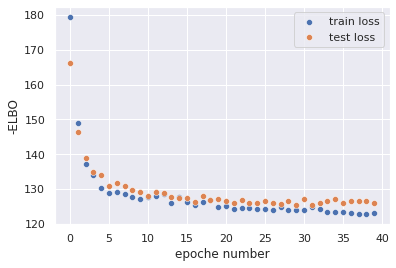

In [5]:
sns.scatterplot(x=np.arange(0,len(err_train)),y=err_train,label="train loss")
sns.scatterplot(x=np.arange(0,len(err_test)),y=err_test,label="test loss")
plt.ylabel(r"-ELBO")
plt.xlabel("epoche number")

tensor([[ 0.6268,  0.0967,  1.0657, -1.2128,  1.0978, -1.2232,  1.1745,  1.0019,
          0.4735, -0.8188],
        [-1.3658, -0.0704,  0.4957, -1.0965,  0.0795, -1.5208,  1.3571,  1.8295,
          0.6281, -0.9349],
        [ 0.3642,  0.0961,  0.9669, -1.1638, -0.2013, -1.4511,  1.3488, -1.8209,
          0.5389, -0.9936],
        [-0.3040,  0.1419, -0.3803, -1.2554,  0.4046, -1.3162,  1.4413, -0.6669,
          0.4936, -0.9935],
        [-2.5200,  0.1332, -1.3015, -1.2226, -1.3509, -1.4241,  1.5592,  0.4228,
          0.5968, -0.9799]], device='cuda:0') cuda:0


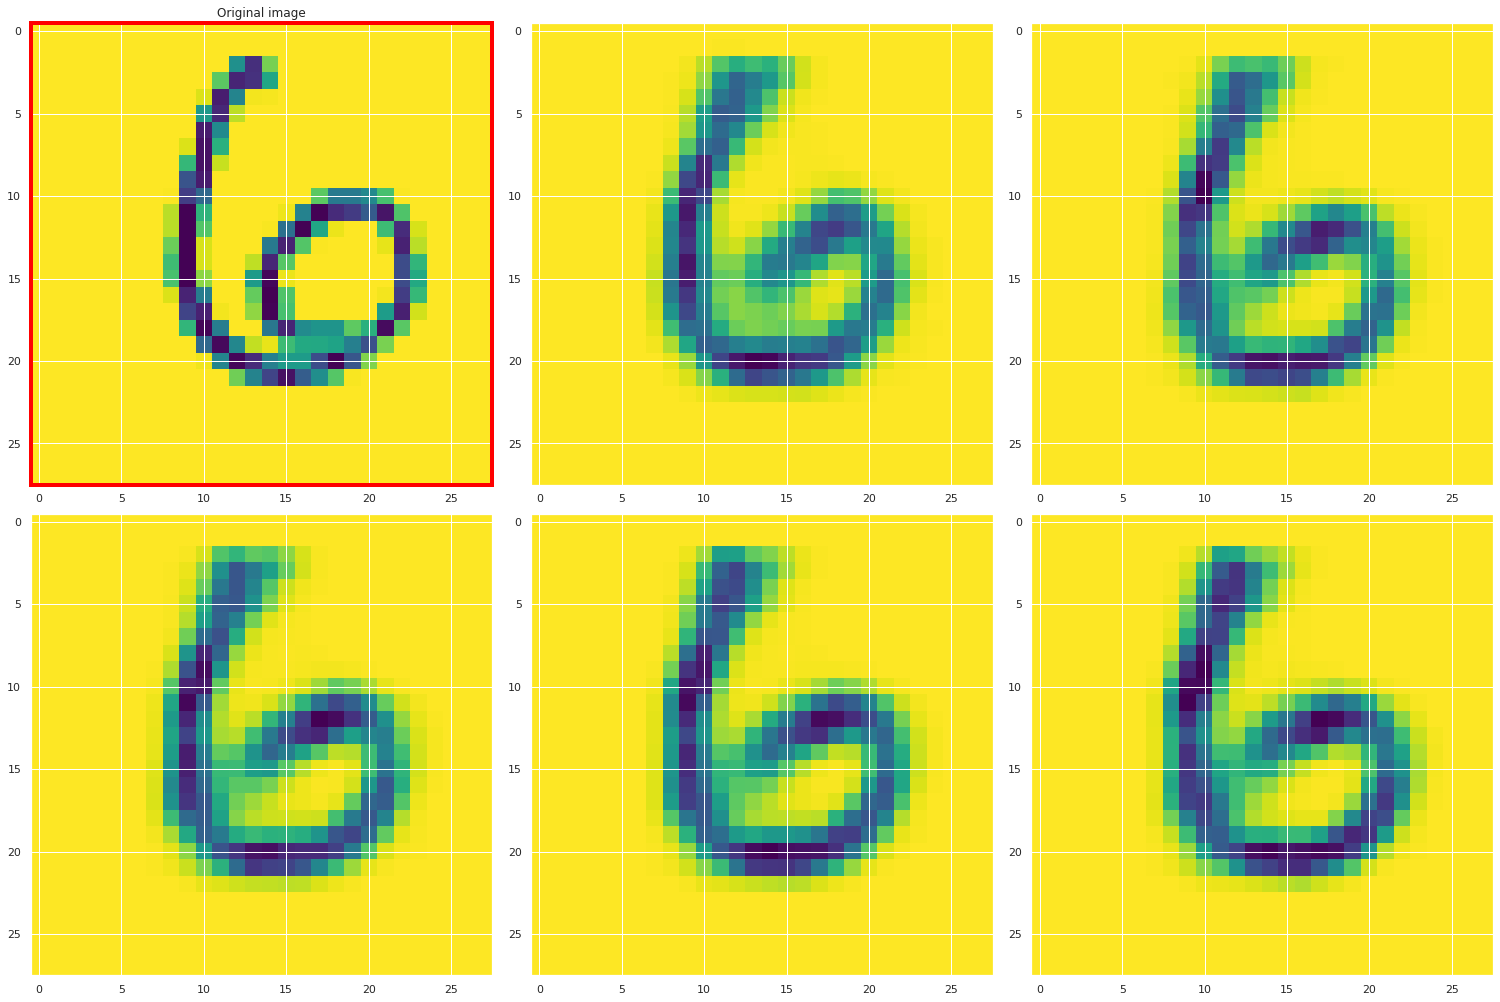

In [6]:
n=100
visualize(xtest[n],VAE)

In [7]:
num_epoch=40    
batch=100
if use_gpu:
    VAE_MSE=VAE_torch(Encoder([784,110,30,10]),Decoder([10,30,110,784]),10,"cuda")
    device = torch.device("cuda" if use_gpu else "cpu")
    xtrain=xtrain.to(device)
    xtest=xtest.to(device)
else:
    VAE_MSE=VAE_torch(Encoder([784,110,30,10]),Decoder([10,30,110,784]),10)
optim=torch.optim.Adam(VAE_MSE.parameters(),lr=0.003)
beta=1
err_train=[]
err_test=[]
for i in range(num_epoch):
    for j in range(0,60000,batch):
        xbatch=xtrain[j:j+batch]
        optim.zero_grad()
        results,mean,sigma=VAE_MSE(xbatch)
        loss=ELBO_MSE(xbatch,results,mean,sigma,beta=beta)
        loss.backward()
        optim.step()
    with torch.no_grad():
        test_res,mean,sigma=VAE_MSE(xtest)
        loss_test=ELBO_MSE(xtest,test_res,mean,sigma,beta=beta)
        print("Epoche: ",i,"loss train: {:.3f}".format(loss.item()),"loss test: {:.3f}".format(loss_test.item()))
        err_train.append(loss.item())
        err_test.append(loss_test.item())

Epoche:  0 loss train: 51.561 loss test: 48.534
Epoche:  1 loss train: 45.388 loss test: 43.556
Epoche:  2 loss train: 41.504 loss test: 40.609
Epoche:  3 loss train: 40.234 loss test: 40.037
Epoche:  4 loss train: 39.919 loss test: 39.866
Epoche:  5 loss train: 39.024 loss test: 39.393
Epoche:  6 loss train: 38.417 loss test: 39.061
Epoche:  7 loss train: 37.934 loss test: 38.739
Epoche:  8 loss train: 38.011 loss test: 38.872
Epoche:  9 loss train: 37.088 loss test: 38.175
Epoche:  10 loss train: 37.058 loss test: 38.292
Epoche:  11 loss train: 37.291 loss test: 38.478
Epoche:  12 loss train: 36.743 loss test: 38.127
Epoche:  13 loss train: 36.596 loss test: 37.991
Epoche:  14 loss train: 36.716 loss test: 37.851
Epoche:  15 loss train: 36.686 loss test: 37.881
Epoche:  16 loss train: 36.566 loss test: 37.635
Epoche:  17 loss train: 36.842 loss test: 37.507
Epoche:  18 loss train: 36.355 loss test: 37.600
Epoche:  19 loss train: 37.262 loss test: 37.703
Epoche:  20 loss train: 35.912

Text(0.5, 0, 'epoche number')

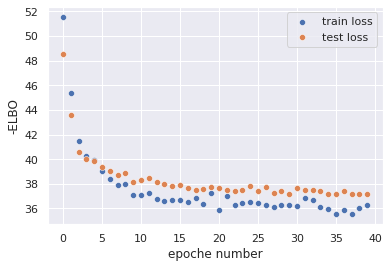

In [8]:
sns.scatterplot(x=np.arange(0,len(err_train)),y=err_train,label="train loss")
sns.scatterplot(x=np.arange(0,len(err_test)),y=err_test,label="test loss")
plt.ylabel(r"-ELBO")
plt.xlabel("epoche number")

tensor([[-0.7608, -0.1280,  1.2408,  0.9959,  1.5101,  0.7798, -0.6193, -0.4152,
         -0.0966,  2.9692],
        [-0.7646,  0.3843,  1.3301,  0.1647, -0.6085,  0.7715, -0.7710,  0.0560,
         -0.0523,  0.0549],
        [-0.8717, -0.2730,  1.3527, -0.7616, -0.6141,  2.4893, -0.9650, -0.0145,
          0.0170, -0.8708],
        [-0.9789, -2.0372,  1.1898,  0.5378,  0.8705,  0.8902, -0.6980, -0.5796,
         -0.0976, -0.2521],
        [-0.7621,  1.0077,  1.2445, -0.2326,  1.2311,  1.8961, -1.0730,  0.9852,
         -0.0250,  1.7623]], device='cuda:0') cuda:0


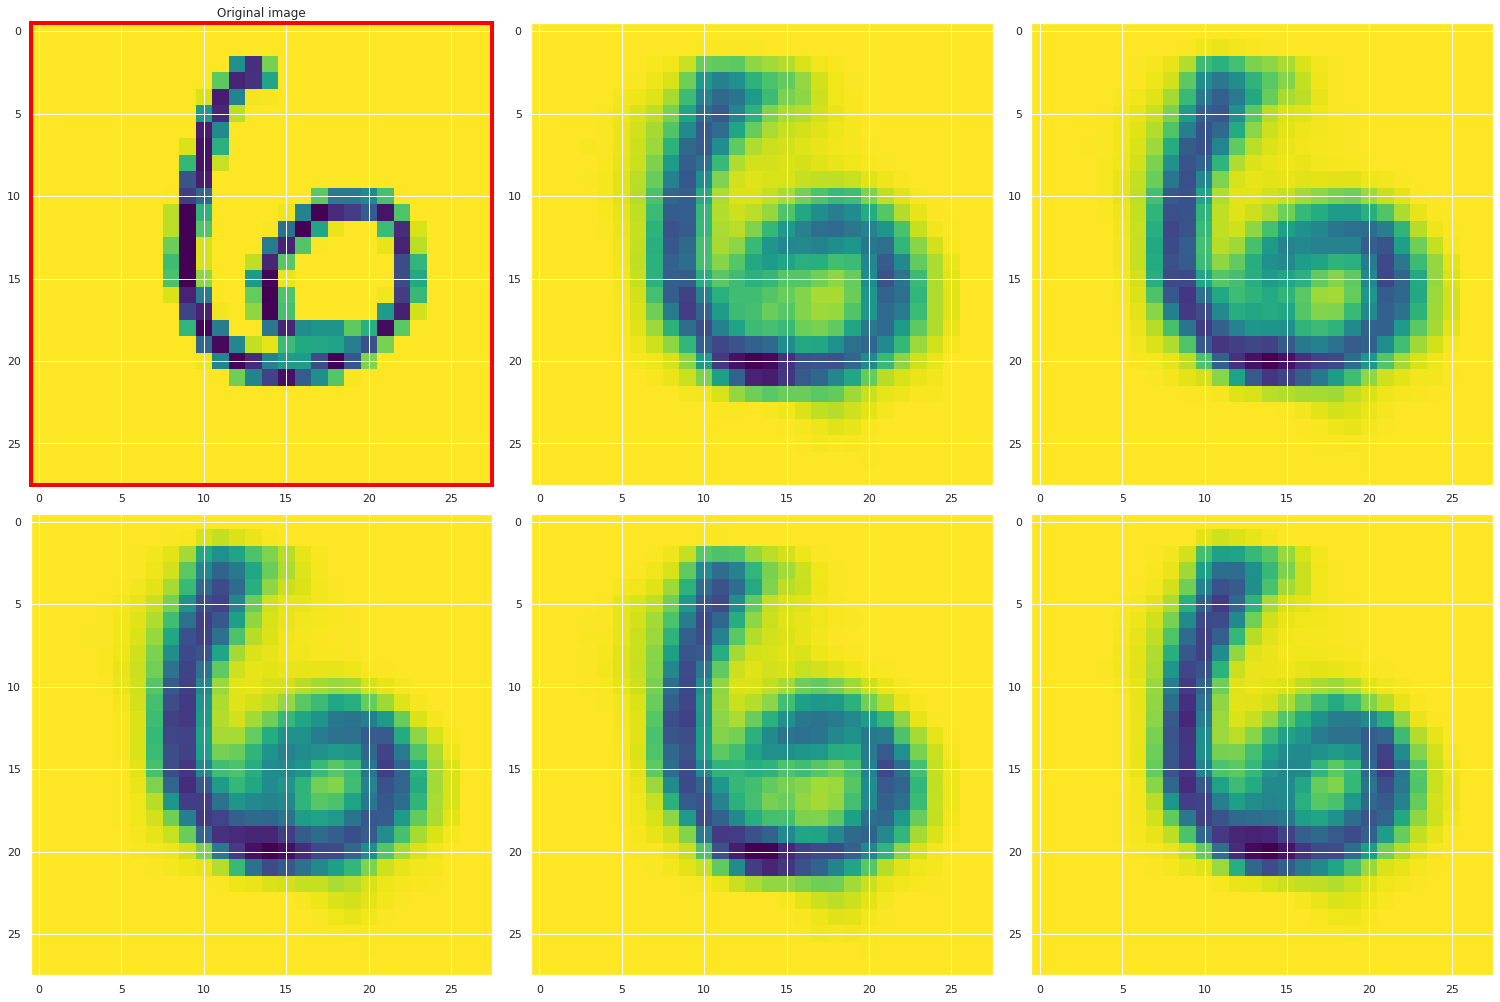

In [9]:
n=100
visualize(xtest[n],VAE_MSE)

In [10]:
generate(VAE,8,"cross_entropy.png")
generate(VAE_MSE,8,"MSE.png")

In [13]:
data=VAE.embed(xtrain).cpu().detach().numpy()

<AxesSubplot: >

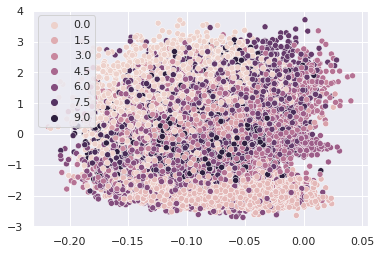

In [22]:
sns.scatterplot(x=data[:,0],y=data[:,1],hue=id)

In [19]:
pca=PCA().fit(data)
values=pca.transform(data)[:,:2]
pca.explained_variance_ratio_

array([2.2249602e-01, 1.8476485e-01, 1.6815984e-01, 1.5264870e-01,
       1.4551291e-01, 1.2611537e-01, 1.3789657e-04, 7.7557037e-05,
       7.2505849e-05, 1.4278292e-05], dtype=float32)

/home/wesenheit/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: >

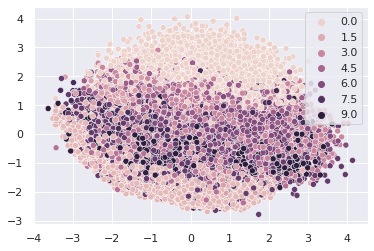

In [20]:
sns.scatterplot(x=values[:,0],y=values[:,1],hue=id)

In [21]:
values_tsne=TSNE(n_components=2, learning_rate='auto',init='random',perplexity=100).fit_transform(data)

<AxesSubplot: >

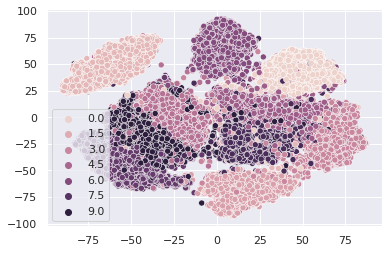

In [23]:
sns.scatterplot(x=values_tsne[:,0],y=values_tsne[:,1],hue=id)